# Assignment 3 Top-Level Code/Notebook
### Training a language model base on Karpathy's minGPT codebase


In [1]:
# The code below is needed for using Google Colab, so un comment this if that is what you're using
import nltk
nltk.download('punkt')
import os

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [2]:
# The code below is also needed for using Google Colab
# BEFORE executing this, you must place the mingpt folder supplied in the assignment
# your google drive, within the folder "Colab Notebooks"
#
# It mounts and changes into the folder that contains mingpt, which you must upload to google drive
# So un-comment it if you've uploaded mingpt to your google drive, into the  "Colab Notebooks" folder
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Colab\ Notebooks/


Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks


In [3]:

import sys

sys.path.insert(0,'/content/drive/My Drive/a3')

In [4]:
import mingpt

In [5]:
import torch
import numpy as np

from nltk.tokenize import sent_tokenize

from pathlib import Path
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset
from torch.utils.data.dataloader import DataLoader
from mingpt.bpe import BPETokenizer
from mingpt.utils import set_seed
set_seed(1234)

In [7]:
"""
Prepare the dataset to train the Language Model (LM)
This implementation splits the sentences and so doesn't create training
examples that cross sentences.

This code is set so that it uses one of two possible datasets, which were also used in Assignment 1:
SmallSimpleCorpus.txt or LargerCorpus.txt

Arguments:
            ds_choice: str. "small" or "large". (i.e. selects which of the two datasets)
            split: str. "train" or "test".
            truncation: int. If -1: no truncation on sentences. Otherwise: truncate to this specific length.
"""

class LanguageModelingDataset(Dataset):

    def __init__(self, ds_choice="small", split="train", truncation=-1):

        base_path = "../"
        fn = {"small": "SmallSimpleCorpus.txt", "large": "LargerCorpus.txt"}
        self.ds_choice = ds_choice
        self.truncation = truncation  # int. If -1, then
        text = Path(base_path, fn[ds_choice]).read_text()
        if ds_choice == "large":
            # Remove the newline char in the middle of sentences
            # The "paragraph splitting" newlines appear to be \n\n -- remove the duplications there
            text = text.replace("\n\n", "$$^^$$").replace("\n", " ").replace("$$^^$$", "\n")
        sentences = sent_tokenize(text)

        # Train / test split
        train, val = train_test_split(sentences, test_size=0.2, shuffle=False)
        if split == "train":
            raw_data = train
        else:
            raw_data = val

        # Tokenize
        self.tokenizer = BPETokenizer()
        self.data = []  # List of 1-d pytorch tensor
        for sent in raw_data:
            tokenized = self.tokenizer(sent).view(-1)  # pytorch tensor
            if truncation >= 0:
                self.data.append(tokenized[:truncation])
            else:
                self.data.append(tokenized)

        # Count some items
        self.max_sentence_length = np.max([len(d) for d in self.data])

    def __len__(self):
        return len(self.data)

    def get_vocab_size(self):
        """
        We have to set this to the max vocab size (i.e., that decided by the BPE tokenizer),
        but actually, only a small number of vocab is used, especially for the small text.
        """
        return 50257

    def __getitem__(self, idx):
        """
        The output should be a tuple x and y, both as pytorch tensors.
        Please refer to the `run()` method in the mingpt/trainer.py script for
        how the x and y are going to be used.
        """
        x = self.data[idx][:-1]
        y = self.data[idx][1:]
        return (x, y)

    def get_block_size(self):
        """
        block_size is the size at which lines are truncated to ensure they are equal-length.
        """
        return self.max_sentence_length

# Instantiate the Training Dataset
#train_dataset = LanguageModelingDataset(ds_choice="small", split="train")  # use this for the short corpus
train_dataset = LanguageModelingDataset(ds_choice="large", split="train", truncation=512) #use this for long

# Instantiate a Validation Dataset (this is only really needed for the fine-tune task, not the LM task)
#val_dataset = LanguageModelingDataset(ds_choice="small", split="validation")
val_dataset = LanguageModelingDataset(ds_choice="large", split="validation", truncation=512)

downloading https://openaipublic.blob.core.windows.net/gpt-2/models/124M/encoder.json to /root/.cache/mingpt/encoder.json
downloading https://openaipublic.blob.core.windows.net/gpt-2/models/124M/vocab.bpe to /root/.cache/mingpt/vocab.bpe


In [8]:
def lm_collate_fn(batch, device):
    x = [item[0] for item in batch]  # List (len B) of varying lengths
    y = [item[1] for item in batch]  # List (len B) of the same lengths as x
    maxlen = max([len(s) for s in x])

    padded_x, padded_y = [], []
    for sx, sy in zip(x, y):
        padded_x.append(torch.cat([sx, torch.ones(maxlen - len(sx))]))
        padded_y.append(torch.cat([sy, torch.ones(maxlen - len(sy))]))
    return torch.stack(padded_x).long().to(device), torch.stack(padded_y).long().to(device)


In [10]:
# Create a Trainer object and set the core hyper-parameters
from mingpt.trainer import Trainer


In [11]:
model_config = GPT.get_default_config()
model_config.model_type = 'gpt-nano'
model_config.vocab_size = train_dataset.get_vocab_size()
model_config.block_size = train_dataset.get_block_size()
model_config.batch_size = 16
model_config.max_iters = 100000
model_config.n_classification_class = 2
p3_model = GPT(model_config)
train_config = Trainer.get_default_config()
train_config.device = "cpu"
#trainer = Trainer(train_config, model, train_dataset, val_dataset, collate_fn=lm_collate_fn)

p3_model.load_state_dict(torch.load('../a3/model_large100K.pt'))


number of parameters: 2.52M


<All keys matched successfully>

In [ ]:
# Another example
encoded_prompt = train_dataset.tokenizer("He and I").to('cpu')
generated_sequence,x,y,z = p3_model.generate(encoded_prompt, 'cpu', temperature=0.6, max_new_tokens=10)
train_dataset.tokenizer.decode(generated_sequence[0])

'He and I\n   the various departments\n   '

In [ ]:
# Another example
encoded_prompt = train_dataset.tokenizer("The new coins").to('cpu')
generated_sequence,x,y,z = p3_model.generate(encoded_prompt, 'cpu', temperature=2, max_new_tokens=14)
train_dataset.tokenizer.decode(generated_sequence[0])

'The new coins\n     of the Mint Mint was sent to be struck'

In [ ]:
encoded_prompt = train_dataset.tokenizer("He said it").to('cpu')
generated_sequence,x,y,z = p3_model.generate(encoded_prompt, 'cpu', temperature=0.8, max_new_tokens=14)
train_dataset.tokenizer.decode(generated_sequence[0])

'He said it a member of the Treasury, and\n     and his'

In [ ]:
# Another example
# This is so bad
encoded_prompt = train_dataset.tokenizer("He is going to").to('cpu')
generated_sequence,x,y,z = p3_model.generate(encoded_prompt, 'cpu', temperature=0.8, max_new_tokens=14)
train_dataset.tokenizer.decode(generated_sequence[0])

'He is going to his father, a years\nengaged to possess to’s'

In [ ]:
# Another example
encoded_prompt = train_dataset.tokenizer("Smoking within").to('cpu')
generated_sequence,x,y,z = p3_model.generate(encoded_prompt, 'cpu', temperature=0.6, max_new_tokens=10)
train_dataset.tokenizer.decode(generated_sequence[0])

'Smoking within the Mint is in work is the\nM of'

In [ ]:
# Example showing how the reloaded model still works
encoded_prompt = train_dataset.tokenizer("She rubs").to('cpu')
generated_sequence,x,y,z = p3_model.generate(encoded_prompt, 'cpu', temperature=0.6, max_new_tokens=10)
train_dataset.tokenizer.decode(generated_sequence[0])

'She rubs about the Mint is a great\n   '

In [ ]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 18.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 17.2 MB/s eta 0:00:00


In [ ]:
import datasets
import pandas as pd
import torch.utils.data as data
from sklearn.model_selection import train_test_split


In [ ]:
glue = datasets.load_dataset("glue", "sst2")

Generating train split:   0%|          | 0/67349 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/872 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1821 [00:00<?, ? examples/s]

In [ ]:
glue['train']

Dataset({
    features: ['sentence', 'label', 'idx'],
    num_rows: 67349
})

In [ ]:
subset = pd.DataFrame(glue['train']).iloc[range(1200)]

In [ ]:
subset

,sentence,label,idx
0,hide new secretions from the parental units,0,0
1,"contains no wit , only labored gags",0,1
2,that loves its characters and communicates som...,1,2
3,remains utterly satisfied to remain the same t...,0,3
4,on the worst revenge-of-the-nerds clichés the ...,0,4
...,...,...,...
1195,more frustrating,0,1195
1196,lacks both a purpose and a strong pulse,0,1196
1197,"there are laughs aplenty , and",1,1197
1198,"lifted from terry gilliam 's subconscious , pr...",1,1198


In [ ]:
train_size = 0.80
validation_size = 0.20
overfit_size = 50
train_set,validate_set = train_test_split(subset, train_size = train_size, stratify=subset['label'])


In [ ]:
train_set

,sentence,label,idx
181,in this wildly uneven movie,0,181
438,`` auto focus '' works as an unusual biopic an...,1,438
431,feeble comedy .,0,431
346,utterly incompetent conclusion,0,346
292,", the film retains ambiguities that make it we...",1,292
...,...,...,...
115,grievous but,0,115
252,"serves as auto-critique , and its clumsiness a...",0,252
215,poignant and leavened,1,215
248,carnage and,0,248


In [ ]:
train_set.to_csv('../a3/train.tsv', sep='\t')
validate_set.to_csv('../a3/validate.tsv', sep='\t')

In [15]:
class TextDataset(torch.utils.data.Dataset):
    def __init__(self, split):
        data_path = "../a3/"
        df = pd.read_csv(os.path.join(data_path, f"{split}.tsv"), sep="\t")

        # X: torch.tensor (maxlen, batch_size), padded indices
        # Y: torch.tensor of len N

        self.tokenizer = BPETokenizer()
        X, Y = [], []
        for i, row in df.iterrows():
            X.append(self.tokenizer((row['sentence'])).squeeze(0))  # Use the last word in the vocab as the "out-of-vocabulary" token
            Y.append(row.label)
        self.X = X
        self.Y = torch.tensor(Y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]


In [16]:
import pandas as pd
import matplotlib.pyplot as plt


In [68]:
val_dataset

,Unnamed: 0,sentence,label,idx
0,425,that it progresses in such a low-key manner th...,0,425
1,496,"hampered -- no , paralyzed -- by a self-indulg...",0,496
2,332,accomplish what few sequels can,1,332
3,977,"a pretty decent kid-pleasing ,",1,977
4,883,make a pretty good team,1,883
...,...,...,...,...
235,198,a plot cobbled together from largely flat and ...,0,198
236,827,should be poignant,0,827
237,815,his story ends or just ca n't tear himself awa...,1,815
238,581,this romantic/comedy asks the question how muc...,0,581


In [17]:
def classify_collate_fn(batch, device):
    x = [item[0] for item in batch]  # List (len B) of varying lengths
    y = [item[1] for item in batch]  # List (len B) of len 1
    maxlen = max([len(s) for s in x])

    padded_x = []
    for sx in x:
        padded_x.append(torch.cat([sx, torch.ones(maxlen - len(sx))]))
    return torch.stack(padded_x).long().to(device), torch.tensor(y).long().to(device)

class TextDataset(torch.utils.data.Dataset):
    def __init__(self, split="train"):
        data_path = "../a3/"
        df = pd.read_csv(os.path.join(data_path, f"{split}.tsv"), sep="\t")

        # X: torch.tensor (maxlen, batch_size), padded indices
        # Y: torch.tensor of len N
        self.tokenizer = BPETokenizer()
        X, Y = [], []
        for i, row in df.iterrows():
            X.append(self.tokenizer((row['sentence'])).squeeze(0))  # Use the last word in the vocab as the "out-of-vocabulary" token
            Y.append(row.label)
        self.X = X
        self.Y = torch.tensor(Y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

In [18]:
"""
Simple training loop; Boilerplate that could apply to any arbitrary neural network,
so nothing in this file really has anything to do with GPT specifically.
"""

import time
from collections import defaultdict

import torch
from torch.utils.data.dataloader import DataLoader
from mingpt.utils import CfgNode as CN

class Trainer:

    @staticmethod
    def get_default_config():
        C = CN()
        # device to train on
        C.device = 'auto'
        # dataloder parameters
        C.num_workers = 4
        # optimizer parameters
        C.max_iters = None
        C.batch_size = 64
        C.learning_rate = 3e-4
        C.betas = (0.9, 0.95)
        C.weight_decay = 0.1 # only applied on matmul weights
        C.grad_norm_clip = 1.0
        return C

    def __init__(self, config, model, train_dataset, validation_dataset, downstream_finetune=False, collate_fn=None):
        self.config = config
        self.model = model
        self.optimizer = None
        self.train_dataset = train_dataset
        self.validation_dataset = validation_dataset
        self.callbacks = defaultdict(list)
        self.collate_fn = collate_fn

        # determine the device we'll train on
        if config.device == 'auto':
            self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        else:
            self.device = config.device
        self.model = self.model.to(self.device)
        print("running on device", self.device)

        # variables that will be assigned to trainer class later for logging and etc
        self.iter_num = 0
        self.iter_time = 0.0
        self.iter_dt = 0.0

        self.validation_loss = []
        self.validation_accuracy = []
        self.training_loss = []
        self.training_accuracy = []

        self.downstream_finetune=downstream_finetune

    def add_callback(self, onevent: str, callback):
        self.callbacks[onevent].append(callback)

    def set_callback(self, onevent: str, callback):
        self.callbacks[onevent] = [callback]

    def trigger_callbacks(self, onevent: str):
        for callback in self.callbacks.get(onevent, []):
            callback(self)

    def accurate_count(self,logits, y):
      rounded_results = torch.round(torch.nn.functional.sigmoid(logits)).squeeze()
      accurate = torch.eq(rounded_results.int(),y.int())
      return accurate.sum()

    def validation(self,data_iter, model):
        data_count = 0
        val_loss = 0
        val_accuracy = 0
        steps = 0
        while True:
            # fetch the next batch (x, y) and re-init iterator if needed
            try:
                batch = next(data_iter)
            except StopIteration:
              break
            steps+=1
            batch = [t.to(self.device) for t in batch]
            x, y = batch
            logits, loss = model(x, y, self.downstream_finetune)
            data_count +=y.size(0)
            val_loss +=loss*y.size(0)
            val_accuracy += self.accurate_count(logits[:,1], y)
            if steps > 15:
              break
        self.validation_loss.append(val_loss/data_count)
        self.validation_accuracy.append(val_accuracy/data_count)


    def run(self):
        model, config = self.model, self.config

        # setup the optimizer
        self.optimizer = model.configure_optimizers(config)

        # setup the dataloader
        train_loader = DataLoader(
            self.train_dataset,
            sampler=torch.utils.data.RandomSampler(self.train_dataset, replacement=True, num_samples=int(1e10)),
            shuffle=False,
            pin_memory=False,
            batch_size=config.batch_size,
            num_workers=config.num_workers,
            collate_fn=lambda batch: self.collate_fn(batch, self.device)
        )
        val_loader = DataLoader(
            self.validation_dataset,
            sampler=torch.utils.data.RandomSampler(self.validation_dataset, replacement=True, num_samples=int(1e10)),
            shuffle=False,
            pin_memory=False,
            batch_size=config.batch_size,
            num_workers=config.num_workers,
            collate_fn=lambda batch: self.collate_fn(batch, self.device)
        )
        model.train()
        self.iter_num = 0
        self.iter_time = time.time()
        data_iter = iter(train_loader)
        val_data_iter = iter(val_loader)
        train_loss = 0
        train_accuracy = 0
        data_count = 0

        while True:

            # fetch the next batch (x, y) and re-init iterator if needed
            try:
                batch = next(data_iter)
            except StopIteration:
                data_iter = iter(train_loader)
                batch = next(data_iter)
            batch = [t.to(self.device) for t in batch]
            x, y = batch
            # forward the model
            logits, self.loss = model(x, y, self.downstream_finetune)

            # backprop and update the parameters
            model.zero_grad(set_to_none=True)
            self.loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), config.grad_norm_clip)
            self.optimizer.step()

            self.trigger_callbacks('on_batch_end')
            self.iter_num += 1
            tnow = time.time()
            self.iter_dt = tnow - self.iter_time
            self.iter_time = tnow

            data_count +=y.size(0)
            train_loss +=self.loss*y.size(0)
            train_accuracy += self.accurate_count(logits[:,1], y)
            if (self.iter_num % 60)==1:
                self.training_loss.append(train_loss/data_count)
                train_loss=0
                self.training_accuracy.append(train_accuracy/data_count)
                train_accuracy = 0
                data_count = 0
                self.validation(val_data_iter, model)
            # termination conditions
            if config.max_iters is not None and self.iter_num >= config.max_iters:
                break


In [19]:
# Create a Trainer object and set the core hyper-parameters
train_config = Trainer.get_default_config()
train_config.learning_rate = 5e-5 # the model we're using is so small that we can go a bit faster
train_config.max_iters = 5000  # For small corpus: 3000 iterations is plenty. For large corpus: 100000 iterations is needed
train_config.num_workers = 0
train_config.batch_size = 16   # For small corpus, batch size of 4 is fine.  For large corpus use 16
trainer = Trainer(train_config, p3_model, train_dataset= TextDataset('train'), validation_dataset=TextDataset('validate'), downstream_finetune=True,collate_fn=classify_collate_fn)

running on device cpu


In [ ]:
train_config.learning_rate = 1e-5 # the model we're using is so small that we can go a bit faster
trainer.run()
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(range(len(trainer.training_loss)), [float(x) for x in trainer.training_loss], label = "train loss")
ax1.plot(range(len(trainer.training_loss)), [float(x) for x in trainer.validation_loss], label = "validation loss")
ax1.legend()

ax2.plot(range(len(trainer.training_loss)), trainer.training_accuracy, label = "train accuracy")
ax2.plot(range(len(trainer.training_loss)), trainer.validation_accuracy, label = "validation accuracy")
ax2.legend()
plt.show()

In [17]:
lrs = [1e-5,1e-6,1e-3,1e-4]
bss = [16,32,64,128,256]

1e-05 16
running on device cpu


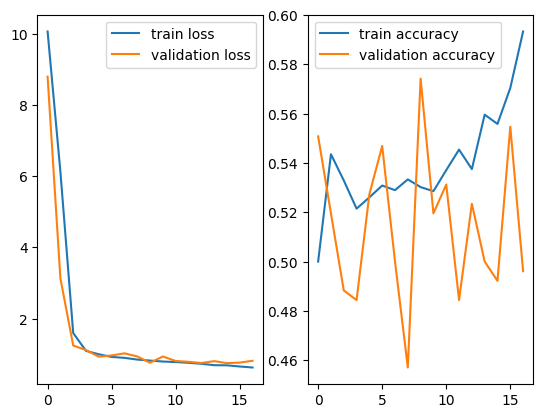

1e-06 16
running on device cpu


KeyboardInterrupt: ignored

In [18]:
for bs in bss:
  for lr in lrs:
    print(lr,bs)
    train_config.batch_size = bs
    train_config.learning_rate = lr
    trainer = Trainer(train_config, p3_model, train_dataset= TextDataset('train'), validation_dataset=TextDataset('validate'), downstream_finetune=True,collate_fn=classify_collate_fn)
    trainer.run()
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.plot(range(len(trainer.training_loss)), [float(x) for x in trainer.training_loss], label = "train loss")
    ax1.plot(range(len(trainer.training_loss)), [float(x) for x in trainer.validation_loss], label = "validation loss")
    ax1.legend()

    ax2.plot(range(len(trainer.training_loss)), trainer.training_accuracy, label = "train accuracy")
    ax2.plot(range(len(trainer.training_loss)), trainer.validation_accuracy, label = "validation accuracy")
    ax2.legend()
    plt.show()

1e-05 16
running on device cpu


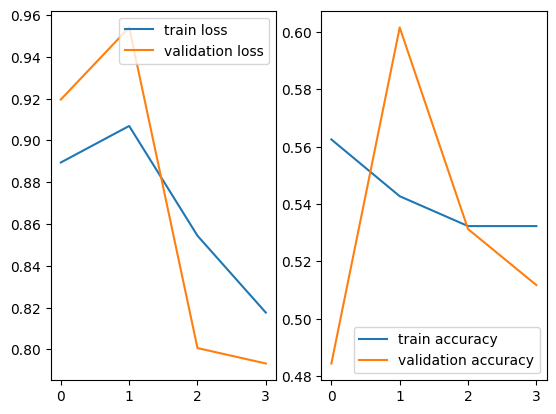

1e-06 16
running on device cpu


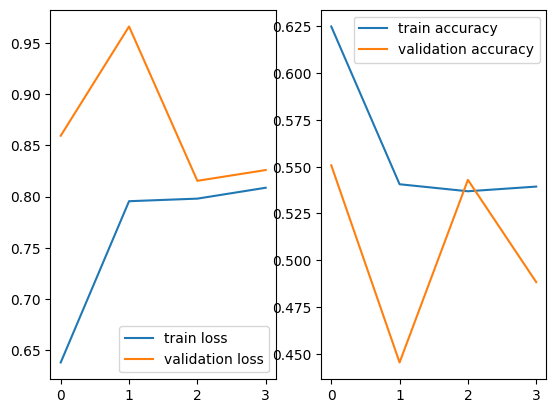

0.001 16
running on device cpu


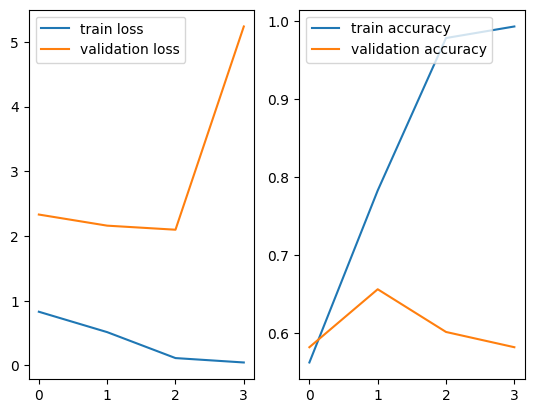

0.0001 16
running on device cpu


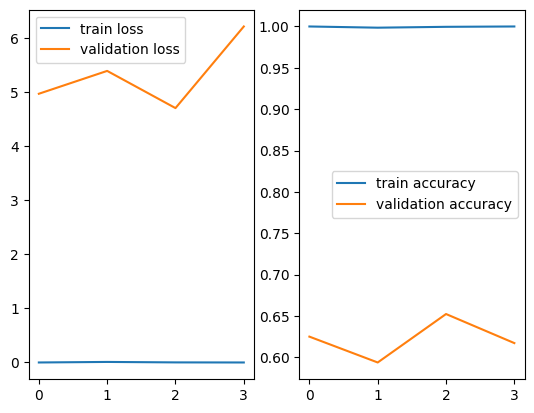

1e-05 32
running on device cpu


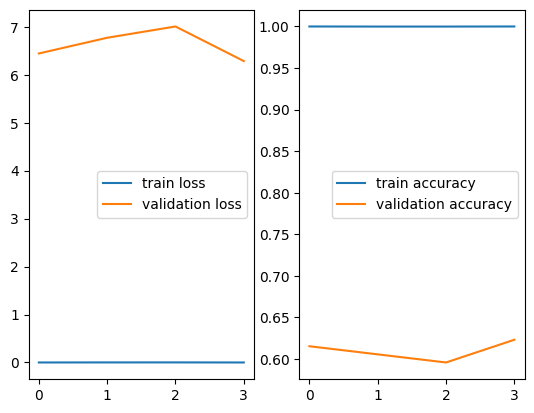

1e-06 32
running on device cpu


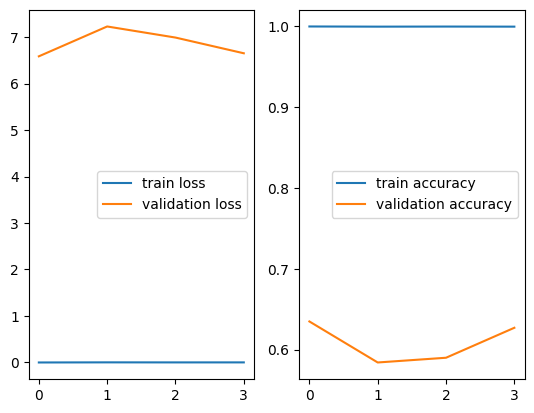

0.001 32
running on device cpu


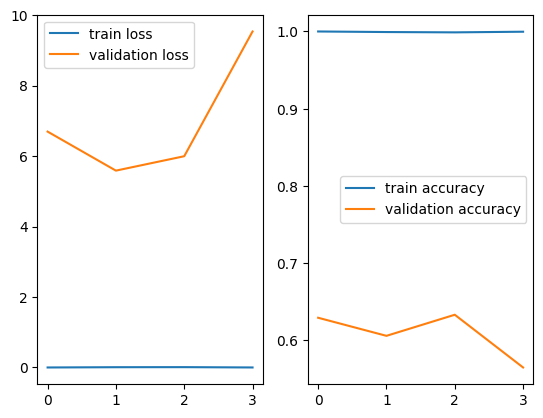

0.0001 32
running on device cpu


KeyboardInterrupt: ignored

In [20]:
for bs in bss:
  for lr in lrs:
    print(lr,bs)
    train_config.batch_size = bs
    train_config.learning_rate = lr
    trainer = Trainer(train_config, p3_model, train_dataset= TextDataset('train'), validation_dataset=TextDataset('validate'), downstream_finetune=True,collate_fn=classify_collate_fn)
    trainer.run()
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.plot(range(len(trainer.training_loss)), [float(x) for x in trainer.training_loss], label = "train loss")
    ax1.plot(range(len(trainer.training_loss)), [float(x) for x in trainer.validation_loss], label = "validation loss")
    ax1.legend()

    ax2.plot(range(len(trainer.training_loss)), trainer.training_accuracy, label = "train accuracy")
    ax2.plot(range(len(trainer.training_loss)), trainer.validation_accuracy, label = "validation accuracy")
    ax2.legend()
    plt.show()

0.0001 16
running on device cpu


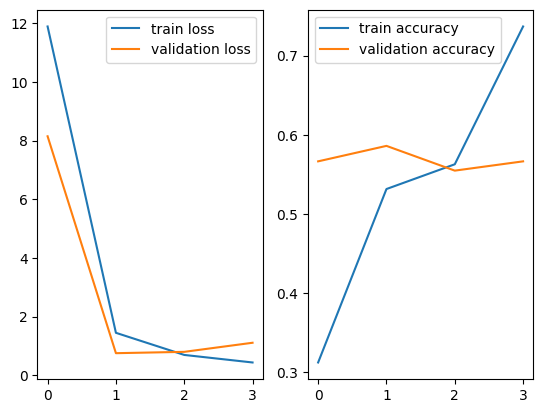

0.0001 32
running on device cpu


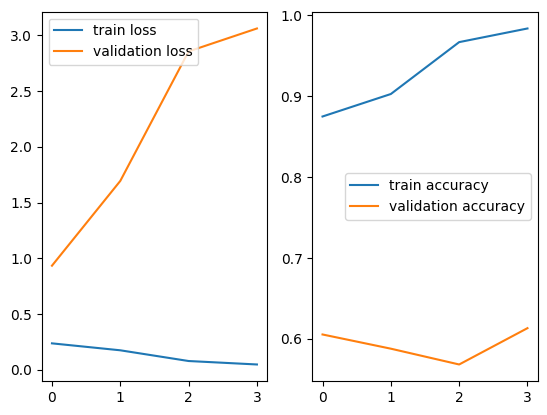

0.0001 64
running on device cpu


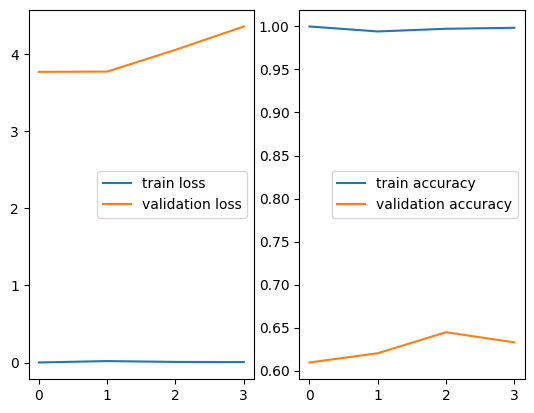

0.0001 128
running on device cpu


In [ ]:
for lr in lrs:
  for bs in bss:
    print(lr,bs)
    train_config.batch_size = bs
    train_config.learning_rate = lr
    trainer = Trainer(train_config, p3_model, train_dataset= TextDataset('train'), validation_dataset=TextDataset('validate'), downstream_finetune=True,collate_fn=classify_collate_fn)
    trainer.run()
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.plot(range(len(trainer.training_loss)), [float(x) for x in trainer.training_loss], label = "train loss")
    ax1.plot(range(len(trainer.training_loss)), [float(x) for x in trainer.validation_loss], label = "validation loss")
    ax1.legend()

    ax2.plot(range(len(trainer.training_loss)), trainer.training_accuracy, label = "train accuracy")
    ax2.plot(range(len(trainer.training_loss)), trainer.validation_accuracy, label = "validation accuracy")
    ax2.legend()
    plt.show()

0.001 16
running on device cpu


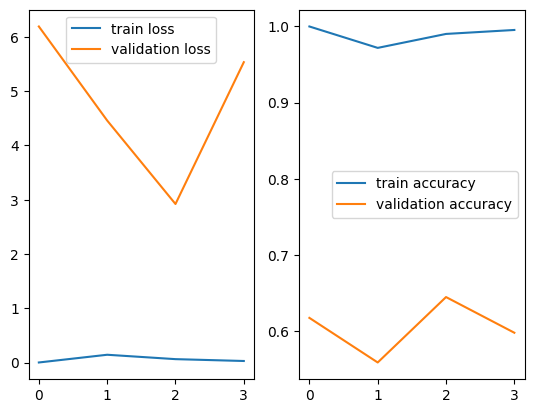

0.001 32
running on device cpu


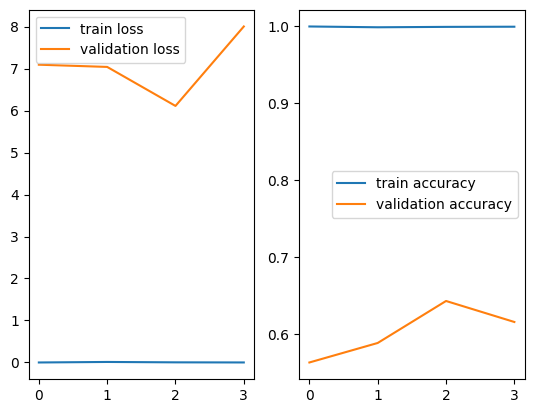

0.001 64
running on device cpu


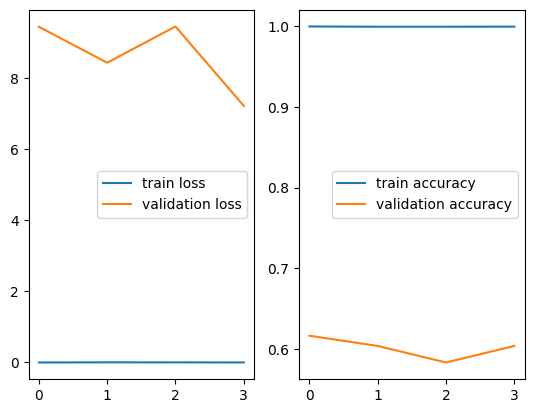

0.001 128
running on device cpu


In [ ]:
for lr in lrs:
  for bs in bss:
    print(lr,bs)
    train_config.batch_size = bs
    train_config.learning_rate = lr
    trainer = Trainer(train_config, p3_model, train_dataset= TextDataset('train'), validation_dataset=TextDataset('validate'), downstream_finetune=True,collate_fn=classify_collate_fn)
    trainer.run()
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.plot(range(len(trainer.training_loss)), [float(x) for x in trainer.training_loss], label = "train loss")
    ax1.plot(range(len(trainer.training_loss)), [float(x) for x in trainer.validation_loss], label = "validation loss")
    ax1.legend()

    ax2.plot(range(len(trainer.training_loss)), trainer.training_accuracy, label = "train accuracy")
    ax2.plot(range(len(trainer.training_loss)), trainer.validation_accuracy, label = "validation accuracy")
    ax2.legend()
    plt.show()

In [1]:
trainer.run()

NameError: ignored

In [20]:
trainer.training_accuracy

[tensor(0.5000), tensor(0.5350), tensor(0.7206), tensor(0.9068)]

In [22]:
trainer.validation_loss

[tensor(8.9357, grad_fn=<DivBackward0>),
 tensor(0.7102, grad_fn=<DivBackward0>),
 tensor(1.2896, grad_fn=<DivBackward0>),
 tensor(1.7548, grad_fn=<DivBackward0>)]

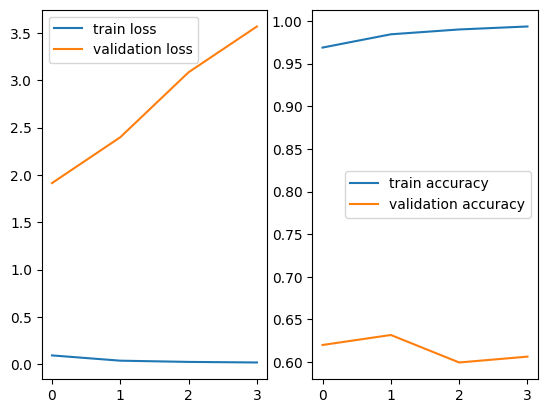

In [28]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(range(len(trainer.training_loss)), [float(x) for x in trainer.training_loss], label = "train loss")
ax1.plot(range(len(trainer.training_loss)), [float(x) for x in trainer.validation_loss], label = "validation loss")
ax1.legend()

ax2.plot(range(len(trainer.training_loss)), trainer.training_accuracy, label = "train accuracy")
ax2.plot(range(len(trainer.training_loss)), trainer.validation_accuracy, label = "validation accuracy")
ax2.legend()
plt.show()


In [ ]:
logits, loss = trainer.model(tokenizer("this is terrific"),finetune_classify=True)
torch.round(torch.nn.functional.sigmoid(logits)).squeeze()

In [ ]:
logits, loss = trainer.model(tokenizer("this is the worst"),finetune_classify=True)
torch.round(torch.nn.functional.sigmoid(logits)).squeeze()

In [ ]:
logits, loss = trainer.model(tokenizer("this is bad"),finetune_classify=True)
torch.round(torch.nn.functional.sigmoid(logits)).squeeze()

In [ ]:
logits, loss = trainer.model(tokenizer("this is good"),finetune_classify=True)
torch.nn.functional.sigmoid(logits)

In [ ]:
logits, loss = trainer.model(tokenizer("this is amazing"),finetune_classify=True)
torch.round(torch.nn.functional.sigmoid(logits)).squeeze()

In [ ]:
tokenizer = BPETokenizer()
tokenizer("She rubs")